In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyspark

     |████████████████████████████████| 281.3 MB 42 kB/s 
     |████████████████████████████████| 198 kB 58.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=6da47ec8efc26568b3a4fa7b8443ea91519d39d851ab88ccf11f0914e0905502
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [3]:
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType,BooleanType,DateType

Create spark session

In [4]:
spark = SparkSession \
    .builder \
    .appName("Spark app") \
    .getOrCreate()

Loading data

In [5]:
path = "/content/drive/MyDrive/Colab Notebooks/datasets/2006.csv"
data = spark.read.csv(path,header=True)
data.count()

7141922

In [ ]:
recursive_loaded_df = spark.read.format("csv")\
    .option("recursiveFileLookup", "true")\
    .option("header",True)\
    .load("/content/drive/MyDrive/Colab Notebooks/datasets/flights")
recursive_loaded_df.take(10)

# Data exploration

In [6]:
#remove some columns
data = data.drop(*("ArrTime","ActualElapsedTime", "AirTime", "TaxiIn", "Diverted", "CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay","LateAircraftDelay", "CancellationCode", "FlightNum", "TailNum", "Year"))

Change the type of the numerical columns


In [7]:
data = data.withColumn("DepTime",data.DepTime.cast('integer'))
data = data.withColumn("CRSArrTime",data.CRSArrTime.cast('integer'))
data = data.withColumn("CRSElapsedTime",data.CRSElapsedTime.cast('integer'))
data = data.withColumn("ArrDelay",data.ArrDelay.cast('integer'))
data = data.withColumn("Distance",data.Distance.cast('integer'))
data = data.withColumn("CRSDepTime",data.CRSDepTime.cast('integer'))
data = data.withColumn("TaxiOut",data.TaxiOut.cast('integer'))
data = data.withColumn("DayOfWeek",data.DayOfWeek.cast('integer'))
data = data.withColumn("DepDelay",data.DepDelay.cast('integer'))

Check for missing values

In [ ]:
from pyspark.sql.functions import isnull, when, count, col

data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+----+-----+----------+---------+-------+----------+----------+-------------+---------+--------------+--------+--------+------+----+--------+-------+---------+----------------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|CRSArrTime|UniqueCarrier|FlightNum|CRSElapsedTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiOut|Cancelled|CancellationCode|
+----+-----+----------+---------+-------+----------+----------+-------------+---------+--------------+--------+--------+------+----+--------+-------+---------+----------------+
|   0|    0|         0|        0| 121934|         0|         0|            0|        0|             4|  138120|  121934|     0|   0|       0|      0|        0|         7019988|
+----+-----+----------+---------+-------+----------+----------+-------------+---------+--------------+--------+--------+------+----+--------+-------+---------+----------------+



Drop the NA

In [8]:
data = data.replace('NA', None)
data = data.na.drop()
data.head(10)

[Row(Month='1', DayofMonth='11', DayOfWeek=3, DepTime=743, CRSDepTime=745, CRSArrTime=1018, UniqueCarrier='US', CRSElapsedTime=273, ArrDelay=6, DepDelay=-2, Origin='ATL', Dest='PHX', Distance=1587, TaxiOut=13, Cancelled='0'),
 Row(Month='1', DayofMonth='11', DayOfWeek=3, DepTime=1053, CRSDepTime=1053, CRSArrTime=1318, UniqueCarrier='US', CRSElapsedTime=265, ArrDelay=-5, DepDelay=0, Origin='ATL', Dest='PHX', Distance=1587, TaxiOut=19, Cancelled='0'),
 Row(Month='1', DayofMonth='11', DayOfWeek=3, DepTime=1915, CRSDepTime=1915, CRSArrTime=2133, UniqueCarrier='US', CRSElapsedTime=258, ArrDelay=-23, DepDelay=0, Origin='ATL', Dest='PHX', Distance=1587, TaxiOut=11, Cancelled='0'),
 Row(Month='1', DayofMonth='11', DayOfWeek=3, DepTime=1753, CRSDepTime=1755, CRSArrTime=1933, UniqueCarrier='US', CRSElapsedTime=158, ArrDelay=-8, DepDelay=-2, Origin='AUS', Dest='PHX', Distance=872, TaxiOut=10, Cancelled='0'),
 Row(Month='1', DayofMonth='11', DayOfWeek=3, DepTime=824, CRSDepTime=832, CRSArrTime=101

In [9]:
data = data.filter((data.Cancelled != 1))

In [10]:
data = data.drop("Cancelled")

In [ ]:
data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+-----+----------+---------+-------+----------+----------+-------------+--------------+--------+--------+------+----+--------+-------+
|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|CRSArrTime|UniqueCarrier|CRSElapsedTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiOut|
+-----+----------+---------+-------+----------+----------+-------------+--------------+--------+--------+------+----+--------+-------+
|    0|         0|        0|      0|         0|         0|            0|             0|       0|       0|     0|   0|       0|      0|
+-----+----------+---------+-------+----------+----------+-------------+--------------+--------+--------+------+----+--------+-------+



Correlation

In [ ]:
data_num = data.drop("UniqueCarrier", "Origin", "Dest")
data_num = data_num.withColumn("Month",data_num.Month.cast('integer'))
data_num = data_num.withColumn("DayofMonth",data_num.DayofMonth.cast('integer'))
data_num = data_num.withColumn("DepDelay",data_num.DepDelay.cast('integer'))

In [ ]:
data_num.printSchema()

root
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiOut: integer (nullable = true)



In [ ]:
for i in data_num.columns:
    print("Corr entre ArrDelay" + " et " + i + ": ", round(data_num.corr("ArrDelay", i, method=None), 5))

Corr entre ArrDelay et Month:  0.03089
Corr entre ArrDelay et DayofMonth:  0.02191
Corr entre ArrDelay et DayOfWeek:  0.0023
Corr entre ArrDelay et DepTime:  0.19831
Corr entre ArrDelay et CRSDepTime:  0.13918
Corr entre ArrDelay et CRSArrTime:  0.13466
Corr entre ArrDelay et CRSElapsedTime:  -0.00423
Corr entre ArrDelay et ArrDelay:  1.0
Corr entre ArrDelay et DepDelay:  0.91894
Corr entre ArrDelay et Distance:  -0.01113
Corr entre ArrDelay et TaxiOut:  0.33108


Airlines, Origin and Destination rankings

In [11]:
data_mean_delay = data.select(*("UniqueCarrier", "DepDelay")).groupby("UniqueCarrier").avg()
origin_delay = data.select(*("Origin","DepDelay")).groupby('Origin').avg()

In [ ]:
data_mean_delay = data_mean_delay.sort(data_mean_delay["avg(DepDelay)"].desc())

In [19]:
from pyspark.sql.functions import udf, monotonically_increasing_id

rank_airline = []
for i in range(1, data_mean_delay.count()+1):
  rank_airline.append(i)
data_mean_delay = data_mean_delay.repartition(1).withColumn(
                  "CarrierRank", 
                  udf(lambda id: rank_airline[id])(monotonically_increasing_id()))
data_mean_delay.show()

+-------------+--------------------+-----------+
|UniqueCarrier|       avg(DepDelay)|CarrierRank|
+-------------+--------------------+-----------+
|           EV|  16.444803057489683|          1|
|           YV|   14.21797578876615|          2|
|           TZ|  12.809553317841466|          3|
|           UA|  11.861670779770893|          4|
|           MQ|  11.406636901216148|          5|
|           B6|  11.281664667941529|          6|
|           CO|  10.989640735354536|          7|
|           FL|  10.947953114437675|          8|
|           AA|  10.660233408096946|          9|
|           WN|  10.266443570144505|         10|
|           XE|   9.845864801604474|         11|
|           OH|   9.340723221049908|         12|
|           AS|   9.241138014992044|         13|
|           OO|   8.822488660275894|         14|
|           DL|   8.075289726692661|         15|
|           US|   7.857690131122144|         16|
|           NW|   6.980419835801923|         17|
|           F9|  5.0

In [ ]:
# from pyspark.sql import Window
# import pyspark.sql.functions as psf

# wM = Window.orderBy(psf.desc("avg(DepDelay)"))
# data_mean_delay = data_mean_delay.withColumn(
#     "CarrierRank", 
#     psf.dense_rank().over(wM)
# )

In [21]:
data = data.join(data_mean_delay, on=['UniqueCarrier'])

In [23]:
data = data.drop("avg(DepDelay)")

In [25]:
origin_delay = origin_delay.sort(origin_delay["avg(DepDelay)"].desc())

In [26]:
rank_origin = []
for i in range(1, origin_delay.count()+1):
  rank_origin.append(i)
origin_delay = origin_delay.repartition(1).withColumn(
                  "OriginRank", 
                  udf(lambda id: rank_origin[id])(monotonically_increasing_id()))
origin_delay.show()

+------+------------------+----------+
|Origin|     avg(DepDelay)|OriginRank|
+------+------------------+----------+
|   ACK| 33.46341463414634|         1|
|   ADK|32.853658536585364|         2|
|   CKB|              20.0|         3|
|   FAY| 19.16370808678501|         4|
|   PFN|18.377441211638104|         5|
|   CWA|18.070628768303187|         6|
|   ORD| 17.67121689741845|         7|
|   AKN| 17.44345238095238|         8|
|   EYW|17.399795501022496|         9|
|   LWB| 17.17098445595855|        10|
|   ISO|16.878260869565217|        11|
|   SPI|16.844975490196077|        12|
|   CEC| 16.66980146290491|        13|
|   BMI|16.587812789620017|        14|
|   SBN|16.511060259344013|        15|
|   AVL|16.116638655462186|        16|
|   AGS| 16.11581793600721|        17|
|   ROA|15.788389977673035|        18|
|   CAE|15.777494072587999|        19|
|   GNV|15.544903581267217|        20|
+------+------------------+----------+
only showing top 20 rows



In [ ]:
# wO = Window.orderBy(psf.desc("avg(DepDelay)"))
# origin_delay = origin_delay.withColumn(
#     "OriginRank", 
#     psf.dense_rank().over(wO)
# )

In [27]:
data = data.join(origin_delay, on=['Origin'])

In [28]:
data = data.drop("avg(DepDelay)")

In [30]:
data = data.drop(*('Origin', 'UniqueCarrier'))

In [32]:
dest_delay = data.select(*("Dest","DepDelay")).groupby('Dest').avg()

In [33]:
dest_delay = dest_delay.sort(dest_delay["avg(DepDelay)"].desc())

In [ ]:
# wD = Window.orderBy(psf.desc("avg(DepDelay)"))
# dest_delay = dest_delay.withColumn(
#     "DestRank", 
#     psf.dense_rank().over(wD)
# )

In [34]:
rank_dest = []
for i in range(1, dest_delay.count()+1):
  rank_dest.append(i)
dest_delay = dest_delay.repartition(1).withColumn(
                  "DestRank", 
                  udf(lambda id: rank_dest[id])(monotonically_increasing_id()))
dest_delay.show()

+----+------------------+--------+
|Dest|     avg(DepDelay)|DestRank|
+----+------------------+--------+
| ACK|31.014634146341464|       1|
| MQT|28.016008537886872|       2|
| MCN| 26.07772511848341|       3|
| ISO|23.394202898550724|       4|
| PFN| 21.38535031847134|       5|
| BMI|  20.7077239488117|       6|
| ILG| 19.78635014836795|       7|
| CWA|19.672103004291845|       8|
| FAY|19.444307692307692|       9|
| RDD| 19.21180030257186|      10|
| CIC| 19.17642276422764|      11|
| AGS|18.659873188405797|      12|
| AVP|18.511413696435724|      13|
| FLO| 18.23949579831933|      14|
| EWR|18.181360811252862|      15|
| CMI|18.010742496050554|      16|
| GNV|17.919095477386936|      17|
| DHN|17.629721362229102|      18|
| CAE|17.497975708502025|      19|
| LNK|17.441228379809388|      20|
+----+------------------+--------+
only showing top 20 rows



In [35]:
data = data.join(dest_delay, on=['Dest'])

In [36]:
data = data.drop("avg(DepDelay)")

In [37]:
data = data.drop("Dest")

In [ ]:
data = data.withColumn("DayofMonth",data.DayofMonth.cast('integer'))
data = data.withColumn("Month",data.Month.cast('integer'))

In [ ]:
data.printSchema()

root
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiOut: integer (nullable = true)
 |-- CarrierRank: integer (nullable = false)
 |-- OriginRank: integer (nullable = false)
 |-- DestRank: integer (nullable = false)



Create a vector column for the features

In [ ]:
from pyspark.ml.feature import VectorAssembler

ignore = ['ArrDelay']
assembler = VectorAssembler(
    inputCols=[x for x in data.columns if x not in ignore],
    outputCol='features')

data = assembler.transform(data)

In [ ]:
data_ml = data.select(['features', 'ArrDelay'])

In [ ]:
data_ml.show()

+--------------------+--------+
|            features|ArrDelay|
+--------------------+--------+
|[1.0,16.0,1.0,210...|     -17|
|[1.0,17.0,2.0,150...|      72|
|[1.0,17.0,2.0,210...|     -17|
|[1.0,18.0,3.0,151...|       5|
|[1.0,18.0,3.0,211...|     -19|
|[1.0,19.0,4.0,145...|      -5|
|[1.0,19.0,4.0,210...|     -19|
|[1.0,20.0,5.0,145...|     -13|
|[1.0,20.0,5.0,210...|     -23|
|[1.0,21.0,6.0,153...|      20|
|[1.0,22.0,7.0,151...|      11|
|[1.0,22.0,7.0,211...|     -14|
|[1.0,23.0,1.0,150...|      -7|
|[1.0,23.0,1.0,210...|     -19|
|[1.0,24.0,2.0,150...|      -1|
|[1.0,24.0,2.0,212...|      -5|
|[1.0,25.0,3.0,150...|      13|
|[1.0,25.0,3.0,210...|      -2|
|[1.0,26.0,4.0,145...|      -1|
|[1.0,26.0,4.0,220...|      39|
+--------------------+--------+
only showing top 20 rows



Trying PCA

In [ ]:
data_pca = data.sample(0.05)

In [ ]:
from pyspark.ml.feature import PCA
pca = PCA(k=2, inputCol="features")
pca.setOutputCol("pca_features")

PCA_af78a1fedf56

In [ ]:
model = pca.fit(data_pca)

In [ ]:
model.setOutputCol("output")

PCAModel: uid=PCA_af78a1fedf56, k=2

In [ ]:
model.explainedVariance

DenseVector([0.5887, 0.3323])

In [ ]:
df_pca = model.transform(data_pca)

In [ ]:
df_pca.show(6)

+-----+----------+---------+-------+----------+----------+--------------+--------+--------+--------+-------+-----------+----------+--------+--------------------+--------------------+
|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|CRSArrTime|CRSElapsedTime|ArrDelay|DepDelay|Distance|TaxiOut|CarrierRank|OriginRank|DestRank|            features|              output|
+-----+----------+---------+-------+----------+----------+--------------+--------+--------+--------+-------+-----------+----------+--------+--------------------+--------------------+
|    1|        20|        5|   2109|      2110|      2242|            92|     -23|      -1|     506|      8|         12|       213|     124|[1.0,20.0,5.0,210...|[-3730.5225234778...|
|    1|        27|        5|   2105|      2110|      2242|            92|     -24|      -5|     506|      8|         12|       213|     124|[1.0,27.0,5.0,210...|[-3728.1045990291...|
|    1|        28|        6|   1454|      1500|      1632|            92|      -9|   

Machine Learning

In [ ]:
#Split the data
(training_data, test_data) = data_ml.randomSplit([0.8,0.2])

In [ ]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = 'features', labelCol='ArrDelay', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(training_data)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.0,0.0,0.0,0.0,0.0,-0.00010826536196192496,-0.022932754944908436,0.9773942139861784,0.0,0.8465517501716281,0.0,0.0254627745125315,0.002901253777727773]
Intercept: -14.942312862140783


In [ ]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 10.904902
r2: 0.911064


In [ ]:
lr_predictions = lr_model.transform(test_data)
#lr_predictions.select("prediction","ArrDelay","features").show(5)

from pyspark.ml.evaluation import RegressionEvaluator

lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="ArrDelay",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

R Squared (R2) on test data = 0.906907


In [ ]:
lr_evaluator_rmse = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="ArrDelay",metricName="rmse")
print("RMSE: %f" % lr_evaluator_rmse.evaluate(lr_predictions))

Py4JError: ignored

In [ ]:
import pandas as pd

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/datasets/2006.csv"
df = pd.read_csv(path)

In [ ]:
df.shape

(7141922, 29)

In [ ]:
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2006,1,11,3,743.0,745,1024.0,1018,US,343,N657AW,281.0,273.0,223.0,6.0,-2.0,ATL,PHX,1587,45,13,0,NaN,0,0,0,0,0,0
1,2006,1,11,3,1053.0,1053,1313.0,1318,US,613,N834AW,260.0,265.0,214.0,-5.0,0.0,ATL,PHX,1587,27,19,0,NaN,0,0,0,0,0,0
2,2006,1,11,3,1915.0,1915,2110.0,2133,US,617,N605AW,235.0,258.0,220.0,-23.0,0.0,ATL,PHX,1587,4,11,0,NaN,0,0,0,0,0,0
3,2006,1,11,3,1753.0,1755,1925.0,1933,US,300,N312AW,152.0,158.0,126.0,-8.0,-2.0,AUS,PHX,872,16,10,0,NaN,0,0,0,0,0,0
4,2006,1,11,3,824.0,832,1015.0,1015,US,765,N309AW,171.0,163.0,132.0,0.0,-8.0,AUS,PHX,872,27,12,0,NaN,0,0,0,0,0,0


In [ ]:
df = df.drop(columns=["ArrTime","ActualElapsedTime", "AirTime", "TaxiIn", "Diverted", "CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay","LateAircraftDelay", "CancellationCode", "FlightNum", "TailNum", "Year"], axis=1)

In [ ]:
df = df.replace(to_replace='NA', value=None)
df = df.dropna()

In [ ]:
df = df[df["Cancelled"] != 1]

In [ ]:
df = df.drop(columns=["Cancelled"], axis=1)

In [ ]:
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,CRSArrTime,UniqueCarrier,CRSElapsedTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiOut
0,1,11,3,743.0,745,1018,US,273.0,6.0,-2.0,ATL,PHX,1587,13
1,1,11,3,1053.0,1053,1318,US,265.0,-5.0,0.0,ATL,PHX,1587,19
2,1,11,3,1915.0,1915,2133,US,258.0,-23.0,0.0,ATL,PHX,1587,11
3,1,11,3,1753.0,1755,1933,US,158.0,-8.0,-2.0,AUS,PHX,872,10
4,1,11,3,824.0,832,1015,US,163.0,0.0,-8.0,AUS,PHX,872,12


In [ ]:
df2 = df.drop(columns=["Month",	"DayofMonth",	"DayOfWeek", "DepTime",	"CRSDepTime",	"CRSArrTime",	"UniqueCarrier", "CRSElapsedTime", "Origin", "Dest", "Distance", "TaxiOut"])

In [ ]:
df2.head()

,ArrDelay,DepDelay
0,6.0,-2.0
1,-5.0,0.0
2,-23.0,0.0
3,-8.0,-2.0
4,0.0,-8.0


In [ ]:
df2.shape

(7003802, 2)

In [ ]:
import seaborn as sns
import scipy as sp
from scipy.stats import chi2
from sklearn.covariance import MinCovDet
import numpy as np

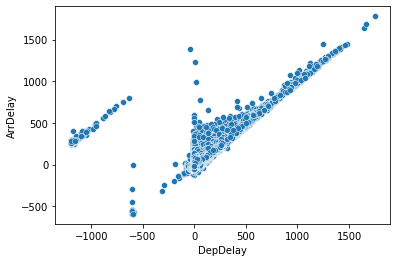

In [ ]:
ax = sns.scatterplot(x="DepDelay", y="ArrDelay", data=df2)

In [ ]:
#Mahalonibis Distance

def mahalanobis_method(df):
    #M-Distance
    x_minus_mu = df - np.mean(df)
    cov = np.cov(df.values.T)                           #Covariance
    inv_covmat = sp.linalg.inv(cov)                     #Inverse covariance
    left_term = np.dot(x_minus_mu, inv_covmat) 
    mahal = np.dot(left_term, x_minus_mu.T)
    md = np.sqrt(mahal.diagonal())
    
    #Flag as outlier
    outlier = []
    #Cut-off point
    C = np.sqrt(chi2.ppf((1-0.001), df=df.shape[1]))    #degrees of freedom = number of variables
    for index, value in enumerate(md):
        if value > C:
            outlier.append(index)
        else:
            continue
    return outlier, md

In [ ]:
outliers_mahal, md = mahalanobis_method(df2)

MemoryError: ignored